# Homework #5

Carina Cheng

# 1) 

In [1]:
import pandas as pd
import sqlite3
import difflib

# Find top 50 airports from csv file
top_airports = '/Users/carinacheng/Desktop/Carina/UCBClasses/python-seminar/Homeworks/hw_5/hw_5_data/top_airports.csv'
df = pd.read_csv(top_airports)
df.sort_values(by='Enplanements',ascending=False) # sort by number of airplane passengers
df.head(50) # top 50
cities = df['City'].tolist() # list of cities
airports = df['Airport'].tolist() # list of airports
codes = df['ICAO'].tolist() # list of airport codes

# Create empty sqlite3 table for airport information
connection = sqlite3.connect("airports.db") # new database
cursor = connection.cursor() 
cursor.execute("""DROP TABLE IF EXISTS airports""") # drop table if exists
sql_cmd = """CREATE TABLE airports (id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT, city TEXT, latitude FLOAT, longitude FLOAT)""" # create table named 'airports'
cursor.execute(sql_cmd) 

# Read latitude/longitude data
info_airports = '/Users/carinacheng/Desktop/Carina/UCBClasses/python-seminar/Homeworks/hw_5/hw_5_data/ICAO_airports.csv'
df = pd.read_csv(info_airports, index_col='name') # index col is airport name
names = df.index.tolist()

# Populate sqlite3 table which will contain airport names, cities, latitudes, and longitudes
print('Top 50 Airports: \n')
for aa,airport in enumerate(airports): # loop through top 50 airports
    try: # if airport names match exactly in both files 
        lat = df.loc[airport]['latitude_deg'] # get latitude
        lon = df.loc[airport]['longitude_deg'] # get longitude
    except: # find closest matching airport name in second file
        airport_short = airport.split('(')[0] # remove parentheticals in name
        name = difflib.get_close_matches(airport_short,names)[0] # take closest matching airport name in second file
        lat = df.loc[name]['latitude_deg'] # get latitude
        lon = df.loc[name]['longitude_deg'] # get longitude
    print(str(aa+1)+'/'+str(len(airports))+': '+airport+' ('+cities[aa]+')')
    data = (airport, cities[aa], lat, lon) # data to save
    sql_cmd = ("INSERT INTO airports (name, city, latitude, longitude) VALUES " + str(data))
    cursor.execute(sql_cmd) # put data into table

# Save and close
connection.commit()
connection.close()

Top 50 Airports: 

1/50: Hartsfield-Jackson Atlanta International Airport (Atlanta)
2/50: Chicago O'Hare International Airport (Chicago)
3/50: Los Angeles International Airport (Los Angeles)
4/50: Dallas/Fort Worth International Airport (Dallas-Fort Worth)
5/50: Denver International Airport (Denver)
6/50: John F. Kennedy International Airport (New York)
7/50: San Francisco International Airport (San Francisco)
8/50: George Bush Intercontinental Airport (Houston)
9/50: McCarran International Airport (Las Vegas)
10/50: Phoenix Sky Harbor International Airport (Phoenix)
11/50: Charlotte/Douglas International Airport (Charlotte)
12/50: Miami International Airport (Miami)
13/50: Orlando International Airport (Orlando)
14/50: Newark Liberty International Airport (Newark)
15/50: Detroit Metropolitan Wayne County Airport (Detroit / Romulus)
16/50: Minneapolis-St. Paul International Airport (Wold-Chamberlain Field) (Minneapolis)
17/50: Seattle-Tacoma International Airport (Seattle / Tacoma (Sea

# 2) and 3)

In [2]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import datetime

# Create empty sqlite3 table for weather information
# Table will contain airport name, date, minimum temp, maximum temp, humidity, and precipitation values
connection = sqlite3.connect("weather.db") # new database
cursor = connection.cursor() 
cursor.execute("""DROP TABLE IF EXISTS weather""") # drop table if exists
sql_cmd = """CREATE TABLE weather (id INTEGER PRIMARY KEY AUTOINCREMENT,
    airport TEXT, date TEXT, min_temp FLOAT, max_temp FLOAT, humidity FLOAT, precipitation FLOAT)""" # create table named 'weather'
cursor.execute(sql_cmd) 

# Pull historical weather data 
# Loop over airports and dates in order to populate tables
print('Pulling weather data over for: \n')
for aa,airport in enumerate(airports): # loop over airports
    print(str(aa+1)+'/'+str(len(airports))+': '+airport)
    code = codes[aa] # airport code
    date_i = 86 # these are the initial indices for pulling data off the wunderground table
    maxt_i = 87
    mint_i = 89
    hum_i = 94
    prec_i = 105
    # get wunderground history for 10 years
    weather_site = 'https://www.wunderground.com/history/airport/'+code+'/2008/3/5/CustomHistory.html?dayend=5&monthend=3&yearend=2018'
    req = requests.get(weather_site)
    soup = BeautifulSoup(req.text,"html.parser")
    page = soup.findAll('td')
    # loop over html table rows (total number of entries divided by entires per row)
    for rr,row in enumerate(range(int((len(page)-86)/21))):
        try: # find date, temperatures, humidity, and precipitation for the row
            url = page[date_i].findAll('a')[0]['href'].split('/Daily')[0] # parse url
            
            # do some hacking to check for missing dates (gaps in data)
            if rr != 0: # get previous date if not the first one
                old_date = datetime.datetime(int(dat.split('/')[0]),int(dat.split('/')[1]),int(dat.split('/')[2]),0,0) # datetime date for previous date
            dat = "/".join(url.split('/')[-3:]) # parse current date from url
            if rr != 0: # get current date if not the first one
                new_date = datetime.datetime(int(dat.split('/')[0]),int(dat.split('/')[1]),int(dat.split('/')[2]),0,0) # datetime date for current date
                if (new_date-old_date).days != 1: # if the gap is more than 1 day
                    for d in range((new_date-old_date).days-1): # fill in missing days
                        date_inc = old_date + datetime.timedelta(1) # increment day
                        dat_inc = "/".join([str(date_inc.year),str(date_inc.month),str(date_inc.day)]) 
                        min_temp = min_temp # fill with previous values (XXX should interpolate instead but...)
                        max_temp = max_temp
                        humidity = humidity
                        precipitation = precipitation
                        data = (str(airport), dat_inc, min_temp, max_temp, humidity, precipitation) # data to save
                        sql_cmd = ("INSERT INTO weather (airport, date, min_temp, max_temp, humidity, precipitation) VALUES " + str(data))
                        cursor.execute(sql_cmd) # put data into table
                        connection.commit() # save
                        old_date = date_inc # increment 
                        
            # if no gaps in dates, then proceed to fill in database (XXX should interpolate here instead...)
            if '-' in page[maxt_i].get_text(): max_temp = max_temp # if no value, use the previous day's value (rarely happens)
            else: max_temp = float(page[maxt_i].get_text()) # get max temp
            if '-' in page[mint_i].get_text(): min_temp = min_temp # if no value, use the previous day's value
            else: min_temp = float(page[mint_i].get_text()) # get min temp
            precipitation = page[prec_i].get_text() # get precipitation
            if '-' in page[hum_i].get_text(): humidity = humidity # if no value, use the previous day's value
            else: humidity = float(page[hum_i].get_text()) # get humidity
                
            if 'T' in precipitation: precipitation = 0.0 # T for 'trace' precipitation ~ 0.0 in. of rainfall
            else: precipitation = float(precipitation) # else it's a float
                
            data = (str(airport), dat, min_temp, max_temp, humidity, precipitation) # data to save
            sql_cmd = ("INSERT INTO weather (airport, date, min_temp, max_temp, humidity, precipitation) VALUES " + str(data))
            cursor.execute(sql_cmd) # put data into table
            connection.commit() # save
        except: pass # if an html row does not match that format (a 'heading' row, for example)
        # increment indices
        date_i += 21 # 21 is the number of entries in each row
        maxt_i += 21
        mint_i += 21
        hum_i += 21
        prec_i += 21
connection.close()

Pulling weather data over for: 

1/50: Hartsfield-Jackson Atlanta International Airport
2/50: Chicago O'Hare International Airport
3/50: Los Angeles International Airport
4/50: Dallas/Fort Worth International Airport
5/50: Denver International Airport
6/50: John F. Kennedy International Airport
7/50: San Francisco International Airport
8/50: George Bush Intercontinental Airport
9/50: McCarran International Airport
10/50: Phoenix Sky Harbor International Airport
11/50: Charlotte/Douglas International Airport
12/50: Miami International Airport
13/50: Orlando International Airport
14/50: Newark Liberty International Airport
15/50: Detroit Metropolitan Wayne County Airport
16/50: Minneapolis-St. Paul International Airport (Wold-Chamberlain Field)
17/50: Seattle-Tacoma International Airport
18/50: Philadelphia International Airport
19/50: Gen. Edward Lawrence Logan International Airport
20/50: LaGuardia Airport (and Marine Air Terminal)
21/50: Washington Dulles International Airport
22/50: 

# 4)

In [5]:
def get_coord(a1,a2,key='longitude'):
    """
    Extracts the latitude or longitude entries for two airportsy (given by key).
        Inputs: a1 (airport 1), a2 (airport 2), key (latitude or longitude)
        Outputs: data1, data2
    """
    try: # try single quotes around airport name
        data1 = cursor2.execute("SELECT "+key+" FROM airports WHERE name == '" + a1 + "'").fetchall()[0][0]
    except: # if that doesn't work, try double quotes
        data1 = cursor2.execute('SELECT '+key+' FROM airports WHERE name == "' + a1 + '"').fetchall()[0][0]
    try: # try single quotes around airport name
        data2 = cursor2.execute("SELECT "+key+" FROM airports WHERE name == '" + a2 + "'").fetchall()[0][0]
    except: # if that doesn't work, try double quotes
        data2 = cursor2.execute('SELECT '+key+' FROM airports WHERE name == "' + a2 + '"').fetchall()[0][0]
    return data1,data2

def get_data(a1,a2,key='precipitation'):
    """
    Extracts entries for two airports given by the key.
        Inputs: a1 (airport 1), a2 (airport 2), key (database key)
        Outputs: data1, data2
    """
    try: # try single quotes around airport name
        sql_cmd = "SELECT " + key + " FROM weather WHERE airport == '" + a1 + "'" # query
        cursor.execute(sql_cmd)
        dat1 = cursor.fetchall()
    except: # if that doesn't work, try double quotes
        sql_cmd = 'SELECT ' + key + ' FROM weather WHERE airport == "' + a1 + '"'
        cursor.execute(sql_cmd)
        dat1 = cursor.fetchall()
    try: # try single quotes around airport name
        sql_cmd = "SELECT " + key + " FROM weather WHERE airport == '" + a2 + "'" # query
        cursor.execute(sql_cmd)
        dat2 = cursor.fetchall()
    except: # if that doesn't work, try double quotes
        sql_cmd = 'SELECT ' + key + ' FROM weather WHERE airport == "' + a2 + '"'
        cursor.execute(sql_cmd)
        dat2 = cursor.fetchall()
    data1, data2 = [], []
    for d in dat1: data1.append(d[0])
    for d in dat2: data2.append(d[0])
    return data1,data2

def compute_corr(a1,a2,offset=0):
    """
    Computes the correlation of precipitation and max temperature between two airports.
        Inputs: a1 (airport1), a2 (airport2), offset (daily offset to compute correlation for)
        Outputs: corr_prec (correlation of precipitation), corr_temp (correlation of max temperature)
    """
    lon1,lon2 = get_coord(a1,a2,key='longitude') # longitudes
    maxt1,maxt2 = get_data(a1,a2,key='max_temp') # max temps
    prec1,prec2 = get_data(a1,a2,key='precipitation') # precipitations
    if lon1 > lon2: # shift first airport data by offset (greater lontigude = more East = more delay in weather)
        maxt1 = np.roll(maxt1,len(maxt1)-offset)
        prec1 = np.roll(prec1,len(prec1)-offset)
    else: # shift second airport data by offset
        maxt2 = np.roll(maxt2,len(maxt2)-offset)
        prec2 = np.roll(prec2,len(prec2)-offset)
    changet1 = np.diff(maxt1) # daily differences
    changet2 = np.diff(maxt2)
    changep1 = np.diff(prec1)
    changep2 = np.diff(prec2)
    corr_t = np.corrcoef(changet1,changet2)[1][0]
    corr_p = np.corrcoef(changep1,changep2)[1][0]
    return np.abs(corr_p), np.abs(corr_t)
    
# Connect to databases
connection = sqlite3.connect("weather.db") # load database   
cursor = connection.cursor() 
connection2 = sqlite3.connect("airports.db") # load database   
cursor2 = connection2.cursor() 

# Make pandas dataframe
corr_table = pd.DataFrame(columns=["Airport 1","Airport 2","1-Day Offset, Precipitation","3-Day Offset, Precipitation",
                                  "7-Day Offset, Precipitation","1-Day Offset, Max Temp","3-Day Offset, Max Temp",
                                  "7-Day Offset, Max Temp"])

# Loop through all airport pairs and populate dataframe
for aa,a1 in enumerate(airports): 
    for a2 in airports[aa+1:]: 
        corr_p_1,corr_t_1 = compute_corr(a1,a2,offset=1) # 1-day offset
        corr_p_3,corr_t_3 = compute_corr(a1,a2,offset=3) # 3-day offset
        corr_p_7,corr_t_7 = compute_corr(a1,a2,offset=7) # 7-day offset
        corr_table.loc[len(corr_table)] = (a1,a2,corr_p_1,corr_p_3,corr_p_7,corr_t_1,corr_t_3,corr_t_7) # save to table
        
print("Correlation strengths between every pair of airports for daily changes of precipitation and maximum temperature, for 1,3, and 7 day offsets: \n")
corr_table # show table

Correlation strengths between every pair of airports for daily changes of precipitation and maximum temperature, for 1,3, and 7 day offsets: 



,Airport 1,Airport 2,"1-Day Offset, Precipitation","3-Day Offset, Precipitation","7-Day Offset, Precipitation","1-Day Offset, Max Temp","3-Day Offset, Max Temp","7-Day Offset, Max Temp"
0,Hartsfield-Jackson Atlanta International Airport,Chicago O'Hare International Airport,0.070425,0.054309,0.038284,0.261508,0.045526,0.024193
1,Hartsfield-Jackson Atlanta International Airport,Los Angeles International Airport,0.007087,0.012142,0.013079,0.259669,0.002376,0.000306
2,Hartsfield-Jackson Atlanta International Airport,Dallas/Fort Worth International Airport,0.102208,0.035027,0.022780,0.302326,0.021193,0.018308
3,Hartsfield-Jackson Atlanta International Airport,Denver International Airport,0.022849,0.126787,0.021633,0.018550,0.073392,0.049266
4,Hartsfield-Jackson Atlanta International Airport,John F. Kennedy International Airport,0.150602,0.103114,0.025990,0.227740,0.160447,0.022792
5,Hartsfield-Jackson Atlanta International Airport,San Francisco International Airport,0.010465,0.098961,0.000769,0.087874,0.037284,0.018407
6,Hartsfield-Jackson Atlanta International Airport,George Bush Intercontinental Airport,0.010906,0.055433,0.054158,0.222197,0.033604,0.042560
7,Hartsfield-Jackson Atlanta International Airport,McCarran International Airport,0.030418,0.031372,0.070296,0.141753,0.054983,0.088543
8,Hartsfield-Jackson Atlanta International Airport,Phoenix Sky Harbor International Airport,0.106542,0.096729,0.015540,0.139095,0.087685,0.049787
9,Hartsfield-Jackson Atlanta International Airport,Charlotte/Douglas International Airport,0.104032,0.067268,0.016242,0.174504,0.215958,0.025367


# 5)

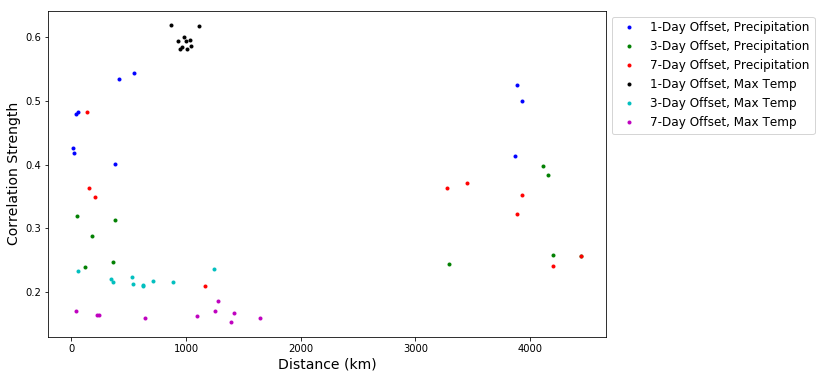

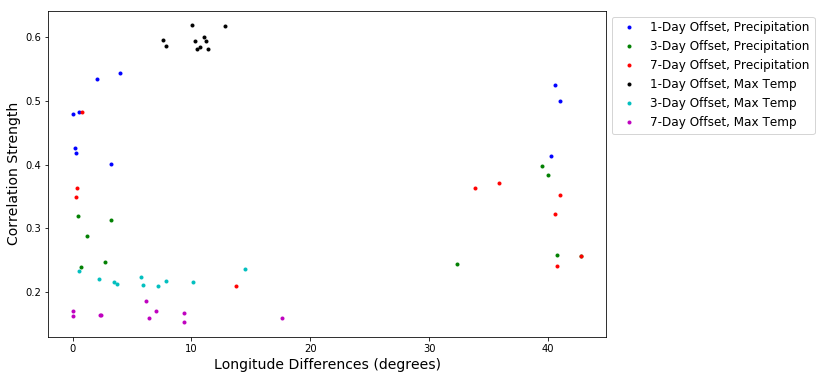

In [6]:
import matplotlib.pyplot as plt
import math

def distance(lat1,lon1,lat2,lon2):
    """
    Computes distance between two points using great circles on Earth.
        Inputs: latitude1, longitude1, latitude2, longitude2 (all in degrees)
        Ouputs: distance (km)
    """
    radius = 6371 # radius of Earth [km]
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

def get_top10(a1_list,a2_list):
    """
    Finds the longitudes and distances associated with the top 10 correlations.
        Inputs: sorted airport list 1, sorted airport list 2 (first entries have highest correlation)
        Outputs: list of longitude differences, list of distances
    """
    longs = [] # longitude differences
    dists = [] # distances
    for aa in range(10): # loop through top 10 airport pairs
        a1 = a1_list[aa] # first airport
        a2 = a2_list[aa] # second airport
        lat1,lat2 = get_coord(a1,a2,key='latitude')
        lon1,lon2 = get_coord(a1,a2,key='longitude')
        dist = distance(lat1,lon1,lat2,lon2)
        longs.append(np.abs(lon2-lon1))
        dists.append(dist)
    return longs, dists

def get_airport_pair(col='1-Day Offset, Precipitation'):
    """
    Sorts pandas table by correlation strengths for a given column and extracts top 10 values.
    Obtains longitude differences and distances for each pair.
        Input: column name (string)
        Outputs: sorted airport list 1, sorted airport list 2, longitude differences, distances, correlation strengths
    """
    corr_table.sort_values(by=[col],ascending=False,inplace=True)
    corr_table.head(10)
    a1_list = corr_table.iloc[:,0][:10].tolist()
    a2_list = corr_table.iloc[:,1][:10].tolist()
    corrs = corr_table[col][:10].tolist()
    longs, dists = get_top10(a1_list,a2_list)
    return a1_list,a2_list,longs,dists,corrs

# Find top 10 correlations in pandas table
a1_p1,a2_p1,longs_p1,dists_p1,corrs_p1 = get_airport_pair(col='1-Day Offset, Precipitation')
a1_p3,a2_p3,longs_p3,dists_p3,corrs_p3 = get_airport_pair(col='3-Day Offset, Precipitation')
a1_p7,a2_p7,longs_p7,dists_p7,corrs_p7 = get_airport_pair(col='7-Day Offset, Precipitation')
a1_t1,a2_t1,longs_t1,dists_t1,corrs_t1 = get_airport_pair(col='1-Day Offset, Max Temp')
a1_t3,a2_t3,longs_t3,dists_t3,corrs_t3 = get_airport_pair(col='3-Day Offset, Max Temp')
a1_t7,a2_t7,longs_t7,dists_t7,corrs_t7 = get_airport_pair(col='7-Day Offset, Max Temp')

# Plot correlation strengths vs. distances
plt.figure(figsize=(10,6))
plt.plot(dists_p1,corrs_p1,'b.',label='1-Day Offset, Precipitation')
plt.plot(dists_p3,corrs_p3,'g.',label='3-Day Offset, Precipitation')
plt.plot(dists_p7,corrs_p7,'r.',label='7-Day Offset, Precipitation')
plt.plot(dists_t1,corrs_t1,'k.',label='1-Day Offset, Max Temp')
plt.plot(dists_t3,corrs_t3,'c.',label='3-Day Offset, Max Temp')
plt.plot(dists_t7,corrs_t7,'m.',label='7-Day Offset, Max Temp')
plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Correlation Strength', fontsize=14)
plt.legend(loc='best',prop={'size':12},bbox_to_anchor=(1,1))
plt.show()

# Plot correlation strengths vs. longitude differences
plt.figure(figsize=(10,6))
plt.plot(longs_p1,corrs_p1,'b.',label='1-Day Offset, Precipitation')
plt.plot(longs_p3,corrs_p3,'g.',label='3-Day Offset, Precipitation')
plt.plot(longs_p7,corrs_p7,'r.',label='7-Day Offset, Precipitation')
plt.plot(longs_t1,corrs_t1,'k.',label='1-Day Offset, Max Temp')
plt.plot(longs_t3,corrs_t3,'c.',label='3-Day Offset, Max Temp')
plt.plot(longs_t7,corrs_t7,'m.',label='7-Day Offset, Max Temp')
plt.xlabel('Longitude Differences (degrees)', fontsize=14)
plt.ylabel('Correlation Strength', fontsize=14)
plt.legend(loc='best',prop={'size':12},bbox_to_anchor=(1,1))
plt.show()

# Close connections
connection.close()
connection2.close()

Analysis: 

The largest correlations are for the "1-Day Offset" case (black and blue), which makes sense because the shorter the time delay, the more similar the weather probably is in two different locations. It also makes sense that the large "1-Day Offset" temperature correlations occur at small distances and small longitude differences, though there are also some correlations at large distances with 1-day offsets, which are likely just random.

There is a slight trend of decreasing correlation strength vs. offset (blue to green to red AND black to cyan to magenta), which is expected since the longer the time delay, the less similar the weather is.

It is also interesting that the two plots look similar - meaning that weather is primarily driven by East/West movement rather than North/South.

I would have expected more red and magenta points (7-day offsets) to preferentially be at large distances than short ones, which is not what we see here. But with only 10 data points for each category, it's tough to distinguish between real trends and random noise. Overall though, I see a higher degree of correlation between precipitation across the country than temperature differentials.